# Comparing Bandit Agents

This notebook compares the performance of different bandit agents.

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os

from bart_playground.bandit.sim_util import *
from compare_agents import (
    compare_agents_across_scenarios, print_summary_results, plot_comparison_results
)
# from bart_playground.bandit.rome.rome_scenarios import HomogeneousScenario, NonlinearScenario

In [2]:
# Define experiment parameters
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, DefaultBARTAgent, MultiChainBARTAgent
# from bart_playground.bandit.neural_ts_agent import NeuralTSDiagAgent

import multiprocessing

from bart_playground.bart import LogisticBART

cores =  multiprocessing.cpu_count() - 1

In [3]:
from typing import List, Tuple, Any
from bart_playground.bandit.agent import BanditAgent

## Tunable Parameters

In [4]:
# Create test scenarios
np.random.seed(0)
    
scenarios = {
    # "Linear": LinearScenario(P=4, K=3, sigma2=1.0),
    # "LinearOffset": LinearOffsetScenario(P=4, K=3, sigma2=1.0),
    # "Offset": OffsetScenario(P=4, K=3, sigma2=1.0),
    # "Offset2": OffsetScenario(P=4, K=3, sigma2=0.1),
    # "Friedman": FriedmanScenario(P=5, K=3, sigma2=1.0, lambda_val=15),
    # "Sparse": FriedmanScenario(P=50, K=3, sigma2=1.0, lambda_val=5),
    
    # "Isolet": OpenMLScenario('isolet', version=1),
    ## "MagicTelescope": OpenMLScenario('MagicTelescope', version=1),
    ## "Adult": OpenMLScenario('adult', version=2),
    # "Shuttle": OpenMLScenario('shuttle', version=1),
    # "Letter": OpenMLScenario('letter', version=1),
    "Mushroom": OpenMLScenario('mushroom', version=1),
    # "Covertype": OpenMLScenario('covertype', version=3),
    # "MNIST_784": OpenMLScenario('mnist_784', version=1),
}

log_encoding = 'native'

np.random.seed(0)

# import torch
# torch.manual_seed(0)
# torch.cuda.manual_seed_all(42)

In [5]:
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, MultiChainBARTAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bart import DefaultBART, LogisticBART

def class_to_agents(sim, scenario_K, scenario_P, agent_classes: List[Any]) -> List[BanditAgent]:
    """
    Convert agent classes to instances.
    """
        # Create agents with different seeds for this simulation
    sim_agents = []
    for agent_cls in agent_classes:
        if agent_cls == BCFAgent:
            agent = BCFAgent(
                n_arms=scenario_K,
                n_features=scenario_P,
                nskip=100,
                ndpost=100,
                nadd=3,
                nbatch=1,
                random_state=1000 + sim
            )
        elif agent_cls == BARTAgent:
            agent = BARTAgent(
                n_arms=scenario_K,
                n_features=scenario_P,
                nskip=50,
                ndpost=50,
                nadd=5,
                random_state=1000 + sim,
                encoding='multi'
            )
        elif agent_cls == LogisticBARTAgent:
            agent = LogisticBARTAgent(
                n_arms=scenario_K,
                n_features=scenario_P,
                nskip=50,
                ndpost=50,
                nadd=1,
                random_state=1000 + sim,
                encoding=log_encoding
            )
        elif agent_cls == MultiChainBARTAgent:
            agent = MultiChainBARTAgent(
                bart_class=LogisticBART,
                n_arms=scenario_K,
                n_features=scenario_P,
                nskip=50,
                ndpost=50,
                nadd=2,
                random_state=1000 + sim,
                encoding=log_encoding
            )
        elif agent_cls == EnsembleAgent:
            agent = EnsembleAgent(
                n_arms=scenario_K,
                n_features=scenario_P,
                bcf_kwargs = dict(nskip=100,
                ndpost=10,
                nadd=2,
                random_state=1000 + sim),
                linear_ts_kwargs = dict(v=1)
            )
        elif agent_cls == BCFAgentPSOff:
            agent = BCFAgentPSOff(
                n_arms=scenario_K,
                n_features=scenario_P,
                nskip=100,
                ndpost=10,
                nadd=2,
                nbatch=1,
                random_state=1000 + sim
            )
        elif agent_cls == LinearTSAgent:
            agent = LinearTSAgent(
                n_arms=scenario_K,
                n_features=scenario_P,
                v = 1
            )
        # elif agent_cls == RoMEAgent:
        #     agent = RoMEAgent(
        #         n_arms=scenario_K,
        #         n_features=scenario_P,
        #         featurize=_featurize,
        #         t_max=n_draws,
        #         pool_users=False
        #     )
        # elif agent_cls == StandardTSAgent:
        #     agent = StandardTSAgent(
        #         n_arms=scenario_K,
        #         n_features=scenario_P,
        #         featurize=_featurize
        #     )
        # elif agent_cls == ActionCenteredTSAgent:
        #     agent = ActionCenteredTSAgent(
        #         n_arms=scenario_K,
        #         n_features=scenario_P,
        #         featurize=_featurize
        #     )
        # elif agent_cls == IntelligentPoolingAgent:
        #     agent = IntelligentPoolingAgent(
        #         n_arms=scenario_K,
        #         n_features=scenario_P,
        #         featurize=_featurize,
        #         t_max=n_draws
        #     )
        else:
            # For other agents, just initialize with standard params
            agent = agent_cls(
                n_arms=scenario_K,
                n_features=scenario_P
            )
        sim_agents.append(agent)
    
    return sim_agents

In [6]:
n_simulations = 4  # Number of simulations per scenario
max_draws = 300      # Number of draws per simulation

def call_func():
    agent_dict = {
        "LinearTS": LinearTSAgent,
        "LinearTS2": LinearTSAgent2,
        # "LogisticBART": LogisticBARTAgent,
        "MultiChainBART": MultiChainBARTAgent,
        # "Neural": NeuralTSDiagAgent,
        # "MBCF+Linear": BCFAgentPSOff,
        # "METS": METSAgent,
        # "HierTS": HierTSAgent
    }
    agent_classes = list(agent_dict.values())
    agent_names = list(agent_dict.keys())
    return compare_agents_across_scenarios(
        scenarios=scenarios,
        n_simulations=n_simulations,
        max_draws=max_draws,
        agent_classes=agent_classes,
        agent_names=agent_names,
        parallel=False,
        class_to_agents=class_to_agents
    )

In [7]:
results = call_func()


Evaluating Mushroom scenario...


Simulating sequentially:   0%|          | 0/4 [00:00<?, ?it/s]2025-06-14 15:21:18,009	INFO worker.py:1908 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Created 4 BARTActor(s) using BART class: LogisticBART
Reshuffling scenario for simulation 0...


Fitting initial BART model with first 10 observations...

 Done.


Simulating sequentially:  25%|██▌       | 1/4 [01:17<03:51, 77.23s/it]

Created 4 BARTActor(s) using BART class: LogisticBART
Reshuffling scenario for simulation 1...


Fitting initial BART model with first 10 observations...

 Done.


Simulating sequentially:  50%|█████     | 2/4 [02:32<02:31, 75.92s/it]

Created 4 BARTActor(s) using BART class: LogisticBART
Reshuffling scenario for simulation 2...


Fitting initial BART model with first 10 observations...

 Done.


Simulating sequentially:  75%|███████▌  | 3/4 [03:51<01:17, 77.42s/it]

Created 4 BARTActor(s) using BART class: LogisticBART
Reshuffling scenario for simulation 3...


Fitting initial BART model with first 10 observations...

 Done.


Simulating sequentially: 100%|██████████| 4/4 [05:19<00:00, 79.87s/it]


## Summary Results

In [8]:
print_summary_results(results)


=== Mushroom Scenario ===

Final cumulative regrets (mean ± std):
  LinearTS: 89.75 (±4.26)
  LinearTS2: 90.25 (±9.63)
  MultiChainBART: 37.25 (±4.71)

Average computation times (seconds):
  LinearTS: 0.0002 (±0.0000)
  LinearTS2: 0.0007 (±0.0001)
  MultiChainBART: 0.2198 (±0.0229)



## Visualize Results

Finally, let's visualize the cumulative regret for each agent across scenarios.

In [9]:
# Create results directory if it doesn't exist
results_dir = "./results/agent_comparison_full_bin"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

import pickle
appendix_name = list(scenarios.keys())[0]  # Use the first scenario name as appendix
result_filename = os.path.join(results_dir, f"result_{appendix_name}.pkl")
pickle.dump((results, max_draws), open(result_filename, "wb"))

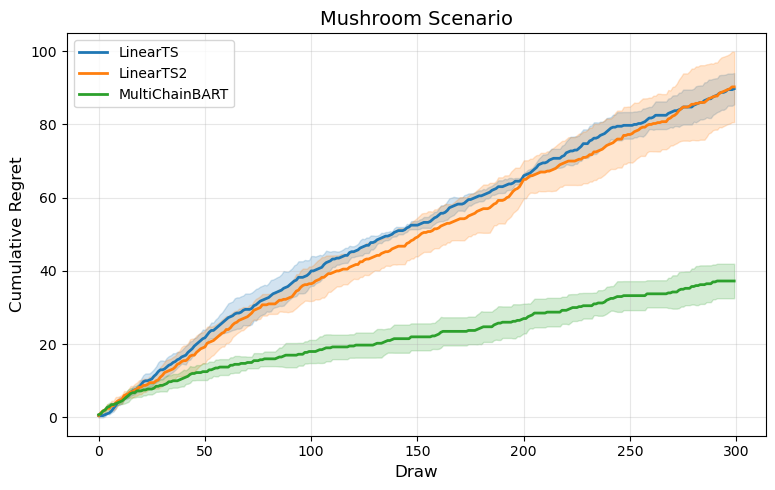

In [10]:
results, max_draws = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    n_draws=max_draws,
    save_path=f"{results_dir}/agent_comparison_results_{appendix_name}.png",
    show_time=False
)

import time
import subprocess
import sys

# try:
#     # Wait for the specified delay
#     time.sleep(100)
#     # Issue the shutdown command
#     subprocess.run(["shutdown", "-h", "now"], check=True)
# except subprocess.CalledProcessError as e:
#     print(f"Failed to shut down: {e}", file=sys.stderr)
#     sys.exit(1)